In [1]:
import torch
import torch_geometric
from torch_geometric.loader import DataLoader
import pytorch_lightning as pl
# ---
from GNN import GNN_model
from dataset import XASMolDataset

In [2]:
print(f'Pytorch version: {torch.__version__}')
print(f'PyG version: {torch_geometric.__version__}')
print(f'Lightning version: {pl.__version__}')

Pytorch version: 2.4.1+cu124
PyG version: 2.5.3
Lightning version: 2.4.0


In [4]:
# --- Path raw directory containing the data
path = "../"
dataset = XASMolDataset(path)
# --- Load and create the dataset
# dataset = torch.load('./processed/cor_pyg.pt')

/home/samjhall/miniconda3/envs/pyg-schnet/lib/python3.11/site-packages/torch_geometric/data/dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) an

In [5]:
# --- Show detail of the dataset
print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print('')

# --- Show details of the first molecule/graph in dataset
data = dataset[0]

print(data)
print('------------')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

XASMolDataset(317)
------------
Number of graphs: 317
Number of features: 15
Number of classes: 0

Data(x=[27, 15], edge_index=[2, 72], edge_attr=[72, 5], spectrum=[200], idx=[1], smiles='c12[c:4]3[c:6]4[c:7]([H:29])[c:9]([H:30])[c:10]5[c:8]3[c:12]3[c:16]6[c:20]1[C:22]1([C:21]([H:36])=[C:19]([H:37])[C:18]6=[C:17]([H:40])[C:15]([H:38])([H:39])[C:14]36[C:13]([H:32])([C:11]5([H:31])[H:35])[O:26]6)[C:23]([H:33])([C:1]([H:27])([H:34])[C:2]23[C:3]([H:28])([C:5]4([H:41])[H:42])[O:24]3)[O:25]1')
------------
Number of nodes: 27
Number of edges: 72
Average node degree: 2.67
Has isolated nodes: False
Has self loops: False
Is undirected: True


In [6]:
# --- Split data into test, validation and test
train_dataset = dataset[0:238]
val_dataset = dataset[238:268]
test_dataset = dataset[268:317]

# --- Pass into dataloader
train_loader = DataLoader(train_dataset, batch_size=238, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=30, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=49, shuffle=False)

print(f'Length of training data loader: {len(train_loader.dataset)}, with a total of {len(train_loader)} datassets')
print(f'Length of validation data loader: {len(val_loader.dataset)}, with a total of {len(val_loader)} datasets')
print(f'Length of testing data loader: {len(test_loader.dataset)}, with a total of {len(test_loader)} datasets')

Length of training data loader: 238, with a total of 1 datassets
Length of validation data loader: 30, with a total of 1 datasets
Length of testing data loader: 49, with a total of 1 datasets


In [7]:
from ray.train.lightning import (
    RayDDPStrategy,
    RayLightningEnvironment,
    RayTrainReportCallback,
    prepare_trainer
)

def train_func(config):
    model = GNN_model(config)

    trainer = L.Trainer(
        accelerator='cpu',
        strategy=RayDDPStrategy(),
        callbacks=[RayTrainReportCallback()],
        plugins=[RayLightningEnvironment()],
    )
    trainer = prepare_trainer(trainer)
    trainer.fit(model, train_loader, val_loader)

In [8]:
from ray import tune
from ray.tune.schedulers import ASHAScheduler

In [9]:
# --- Define parameters for GNN model
config = {
    "num_tasks": 200,
    "num_layer": 3,
    "in_channels": [dataset.num_features, 64, 128],
    "out_channels": [64, 128, 256],
    "gnn_type": "gcn",
    "heads": 1,
    "drop_ratio": 0.3,
    "graph_pooling": "mean",
    "lr": tune.loguniform(1e-4, 0.1)
}

In [10]:
num_epochs = 10
num_samples = 10
scheduler = ASHAScheduler(max_t=num_epochs, grace_period=1, reduction_factor=2)

In [11]:
from ray.train import RunConfig, ScalingConfig, CheckpointConfig

scaling_config = ScalingConfig(
    num_workers=1, use_gpu=False, resources_per_worker={'CPU': 1, 'GPU': 0}
)

run_config = RunConfig(
    checkpoint_config=CheckpointConfig(
        num_to_keep=2,
        checkpoint_score_attribute="ptl/val_loss",
        checkpoint_score_order='min'
    )
)

In [12]:
from ray.train.torch import TorchTrainer

ray_trainer = TorchTrainer(
    train_func,
    scaling_config=scaling_config,
    run_config=run_config
)

In [13]:
def tune_asha(num_samples=10):
    scheduler = ASHAScheduler(
        max_t=num_epochs, grace_period=1, reduction_factor=2
    )

    tuner = tune.Tuner(
        ray_trainer,
        param_space={'train_loop_config': config},
        tune_config=tune.TuneConfig(
            metric="ptl/val_loss",
            mode="min",
            num_samples=num_samples,
            scheduler=scheduler
        )
    )
    return tuner.fit()

In [14]:
results = tune_asha(num_samples=num_samples)

2024-11-11 16:23:31,548	INFO data_parallel_trainer.py:340 -- GPUs are detected in your Ray cluster, but GPU training is not enabled for this trainer. To enable GPU training, make sure to set `use_gpu` to True in your scaling config.
2024-11-11 16:23:31,552	INFO data_parallel_trainer.py:340 -- GPUs are detected in your Ray cluster, but GPU training is not enabled for this trainer. To enable GPU training, make sure to set `use_gpu` to True in your scaling config.
2024-11-11 16:23:31,557	INFO data_parallel_trainer.py:340 -- GPUs are detected in your Ray cluster, but GPU training is not enabled for this trainer. To enable GPU training, make sure to set `use_gpu` to True in your scaling config.
2024-11-11 16:23:31,561	INFO data_parallel_trainer.py:340 -- GPUs are detected in your Ray cluster, but GPU training is not enabled for this trainer. To enable GPU training, make sure to set `use_gpu` to True in your scaling config.
2024-11-11 16:23:31,563	INFO data_parallel_trainer.py:340 -- GPUs ar

(raylet) [2024-11-11 16:24:30,997 E 156630 156630] (raylet) node_manager.cc:3065: 5 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: ccaca6f13b23c1d435962cfc02dd116f93442a48f18e9989fabc0774, IP: 172.21.39.13) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.21.39.13`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


In [15]:
model = GNN_model(config)
model

GNN_model(
  (convs): ModuleList(
    (0): GCNConv(6, 64)
    (1): GCNConv(64, 128)
    (2): GCNConv(128, 256)
  )
  (batch_norms): ModuleList(
    (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (graph_pred_linear): Linear(in_features=256, out_features=200, bias=True)
)

In [16]:
# --- Seed for reproducability
pl.seed_everything(1994, workers=True)
torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms=True
# --- Path to save model
path = './ml_model'
logger = pl.loggers.TensorBoardLogger(save_dir=path)
# --- Lightining trainer
trainer = pl.Trainer(logger=logger,
                    default_root_dir=path,
                    max_epochs=50, 
                    accelerator='auto',
                    log_every_n_steps=1)

Seed set to 1994
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [17]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params | Mode 
---------------------------------------------------------
0 | convs             | ModuleList | 41.8 K | train
1 | batch_norms       | ModuleList | 896    | train
2 | graph_pred_linear | Linear     | 51.4 K | train
---------------------------------------------------------
94.1 K    Trainable params
0         Non-trainable params
94.1 K    Total params
0.376     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [38]:
checkpoint = './ml_model/lightning_logs/version_1/checkpoints/epoch=499-step=500.ckpt'

test_model = GNN_model.load_from_checkpoint(checkpoint, hparams_file='./ml_model/lightning_logs/version_0/hparams.yaml')

In [11]:
trainer.test(model, test_loader)

/home/samjhall/miniconda3/envs/pyg-schnet/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.85it/s] 


/home/samjhall/miniconda3/envs/pyg-schnet/lib/python3.11/site-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1471. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.006667571607977152    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.006667571607977152}]

In [16]:
test_dataset[0]

Data(x=[29, 6], edge_index=[2, 72], edge_attr=[72, 5], spectrum=[200], idx=[1], smiles='c12[c:4]3[c:8]4[c:10]5[c:11]([H:31])[c:13]([H:32])[c:14]6[c:12]4[c:16]4[c:18]([c:17]([H:40])[c:15]6[C:24](=[O:28])[H:39])[c:19]([H:33])[c:21]([H:34])[c:22]([c:20]14)[C:23](=[O:26])[C:1]([H:36])=[C:2]2[C:3]([H:37])([H:38])[C:5]([O:25][H:35])=[C:6]3[C:7]1([H:29])[C:9]5([H:30])[O:27]1')

In [39]:
test_model.eval()

GNN_light(
  (convs): ModuleList(
    (0): GCNConv(6, 64)
    (1): GCNConv(64, 128)
    (2): GCNConv(128, 256)
  )
  (batch_norms): ModuleList(
    (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (graph_pred_linear): Linear(in_features=256, out_features=200, bias=True)
)

In [46]:
x = 23

with torch.no_grad():
    test = test_model(test_dataset[x])

In [47]:
flat = torch.flatten(test)

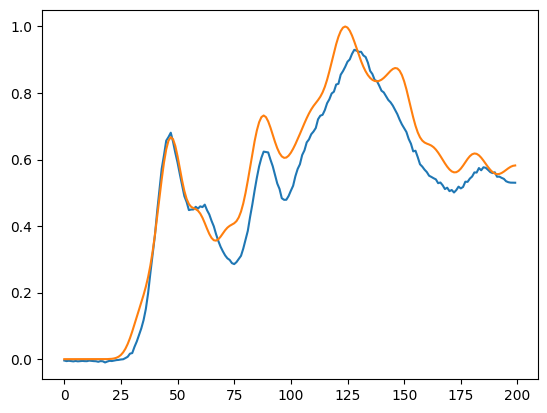

In [48]:
import matplotlib.pyplot as plt
plt.plot(flat)
plt.plot(test_dataset[x].spectrum)
plt.show()